In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split
import pickle

In [11]:
root_dir = "seg_train/seg_train"
image_list = []
label_list = []

for directory in os.listdir(root_dir):
    directory_path = join(root_dir, directory)
    if os.path.isdir(directory_path):
        for file_name in os.listdir(directory_path):
            file_path = join(directory_path, file_name)
            if isfile(file_path):
                image = Image.open(file_path)
                image = image.resize((150, 150))
                image = img_to_array(image)
                image_list.append(image)
                label_list.append(directory)

In [12]:
df_labels = pd.DataFrame(label_list).value_counts()
df_labels

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
dtype: int64

In [13]:
np.array(image_list).shape

(14034, 150, 150, 3)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state=4242) 

In [15]:
# Normalization
X_train = np.array(X_train, dtype=np.float16) / 225.0
X_test = np.array(X_test, dtype=np.float16) / 225.0

In [16]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [17]:
pickle.dump(lb, open("lb.pkl", "wb"))

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [19]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150, 150, 3)),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2D(32, kernel_size=(3,3)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(5,5),
    
    Flatten(),
    
    Dense(32),
    Dropout(rate=0.2),
    BatchNormalization(),
    LeakyReLU(),
    
    Dense(16),
    Dropout(rate=0.2),
    BatchNormalization(),
    LeakyReLU(1),
    
    Dense(6, activation="softmax")
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 16)     64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 148, 148, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_5 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 146, 146, 32)     

In [21]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005), metrics=["accuracy"])

In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
71/71 [==============================] - 91s 1s/step - loss: 1.2414 - accuracy: 0.5332 - val_loss: 1.9459 - val_accuracy: 0.1563
Epoch 2/10
71/71 [==============================] - 88s 1s/step - loss: 0.9234 - accuracy: 0.6782 - val_loss: 2.1873 - val_accuracy: 0.1558
Epoch 3/10
71/71 [==============================] - 88s 1s/step - loss: 0.7711 - accuracy: 0.7415 - val_loss: 1.8476 - val_accuracy: 0.1812
Epoch 4/10
71/71 [==============================] - 87s 1s/step - loss: 0.6806 - accuracy: 0.7747 - val_loss: 1.4084 - val_accuracy: 0.4506
Epoch 5/10
71/71 [==============================] - 101s 1s/step - loss: 0.6055 - accuracy: 0.7970 - val_loss: 1.1831 - val_accuracy: 0.5419
Epoch 6/10
71/71 [==============================] - 94s 1s/step - loss: 0.5396 - accuracy: 0.8260 - val_loss: 0.8685 - val_accuracy: 0.6906
Epoch 7/10
71/71 [==============================] - 94s 1s/step - loss: 0.4741 - accuracy: 0.8535 - val_loss: 0.7553 - val_accuracy: 0.7324
Epoch 8/10
71/71 [=

In [23]:
model.save("intel_image.h5")

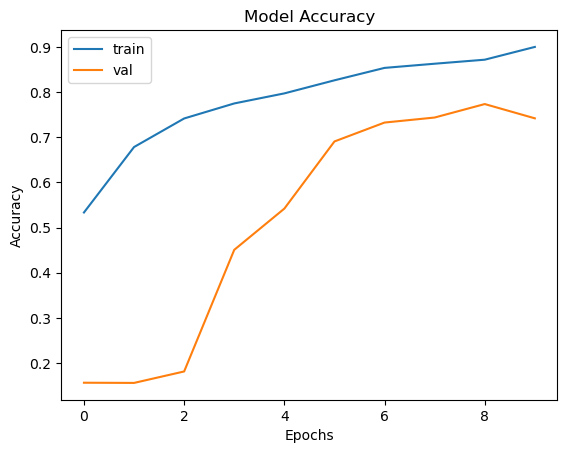

In [24]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

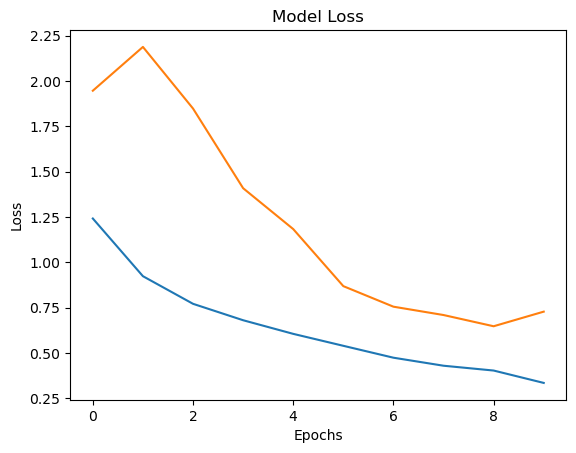

In [25]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [26]:
scores = model.evaluate(X_test, y_test)
acc = scores[1] * 100
print("Test Accuracy:", acc)

88/88 [==============================] - 11s 123ms/step - loss: 0.7623 - accuracy: 0.7186
Test Accuracy: 71.85607552528381


In [27]:
y_pred = model.predict(X_test)

88/88 [==============================] - 11s 120ms/step


In [28]:
labels = lb.classes_
print("Originally : ",labels[np.argmax(y_test[44])])
print("Predicted : ",labels[np.argmax(y_pred[44])])

Originally :  buildings
Predicted :  buildings


In [29]:
count = 0
for i in range(1, 100):
    if labels[np.argmax(y_test[i])] == labels[np.argmax(y_pred[i])]:
        count += 1
        
print(count , "%")

80 %
